In [1]:
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt
import scripts.mytools as mytools

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

In [3]:
df = pd.read_csv('raw_data/dados_A215_H_2008-06-13_2024-01-01.csv',sep= ';', header = 9)
df['Data Medicao'] = pd.to_datetime(df['Data Medicao'])
df['Hora Medicao'] = pd.to_datetime(df['Hora Medicao'])
df['ano'] = df['Data Medicao'].dt.year
df['mes'] = df['Data Medicao'].dt.month
df['dia'] = df['Data Medicao'].dt.day
# df['hora']= df['Hora Medicao'].str[-4:-2].astype(int)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '.').astype(float)


df['Hora Medicao'] = df['Hora Medicao'].astype(str)
df['hora'] = df['Hora Medicao'].str[-4:-2].astype(int)
df = df.drop(['Hora Medicao'],axis=1)
df['hora'] = pd.to_timedelta(df['hora'], unit='h') - pd.Timedelta(hours=3)
df['Data_Hora'] = df['Data Medicao'] + df['hora']
df.set_index('Data_Hora', inplace=True)
df['Data_Hora'] = df['Data Medicao'] + df['hora']
df = df.drop('Unnamed: 22', axis =1)
df['estacao'] = df.apply(mytools.encontrar_estacao, axis=1)


In [4]:
ml_cropped = mytools.cortar_serie_temporal(df,data_inicio = '2010-01-01', data_fim = '2019-12-31')
extrapolation = mytools.cortar_serie_temporal(df,data_inicio = '2020-01-01', data_fim = '2024-01-01')


In [5]:
'''def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    pylab.rcParams['figure.figsize'] = (16, 8)
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns')
    '''

'def plot_missing_values(df):\n    """ For each column with missing values plot proportion that is missing."""\n    data = [(col, df[col].isnull().sum() / len(df)) \n            for col in df.columns if df[col].isnull().sum() > 0]\n    col_names = [\'column\', \'percent_missing\']\n    missing_df = pd.DataFrame(data, columns=col_names).sort_values(\'percent_missing\')\n    pylab.rcParams[\'figure.figsize\'] = (16, 8)\n    missing_df.plot(kind=\'barh\', x=\'column\', y=\'percent_missing\'); \n    plt.title(\'Percent of missing values in colummns\')\n    '

In [6]:
col_numericas = [
    'PRECIPITACAO TOTAL, HORARIO(mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)',
    'PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)',
    'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)',
    'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)',
    'RADIACAO GLOBAL(Kj/m²)', 'TEMPERATURA DA CPU DA ESTACAO(°C)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)',
    'TEMPERATURA DO PONTO DE ORVALHO(°C)',
    'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)',
    'TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C)',
    'TENSAO DA BATERIA DA ESTACAO(V)',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)',
    'UMIDADE RELATIVA DO AR, HORARIA(%)', 'VENTO, RAJADA MAXIMA(m/s)',
    'VENTO, VELOCIDADE HORARIA(m/s)'
]


In [7]:
# df = df.dropna()

In [8]:
outliers_df = mytools.IQR_Outliers(df,col_numericas)
outliers_df = pd.DataFrame(outliers_df)

# of features:  19
Features:  ['PRECIPITACAO TOTAL, HORARIO(mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)', 'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)', 'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'TEMPERATURA DA CPU DA ESTACAO(°C)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)', 'TEMPERATURA DO PONTO DE ORVALHO(°C)', 'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)', 'TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C)', 'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C)', 'TENSAO DA BATERIA DA ESTACAO(V)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE RELATIVA DO AR, HORARIA(%)', 'VENTO, RAJADA MAXIMA(m/s)', 'VENTO, VELOCIDADE HORARIA(m/s)']
Number of samples:  136344

Feature:  PRECIPITACAO TOTAL, HORARIO(mm)
Upper and Lower limits:  0.0 0.0
Number of outliers:  12413
Outliers Index:  [Timestamp('2

In [9]:
outliers_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,"PRECIPITACAO TOTAL, HORARIO(mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORAR...","PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT...",PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB),PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB),RADIACAO GLOBAL(Kj/m²),TEMPERATURA DA CPU DA ESTACAO(°C),"TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)",TEMPERATURA DO PONTO DE ORVALHO(°C),TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C),TENSAO DA BATERIA DA ESTACAO(V),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),"UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, RAJADA MAXIMA(m/s)","VENTO, VELOCIDADE HORARIA(m/s)"
1,12413,556,556,535,732,32,0,978,9549,306,1528,8158,10260,301,3789,4692,4425,63,0


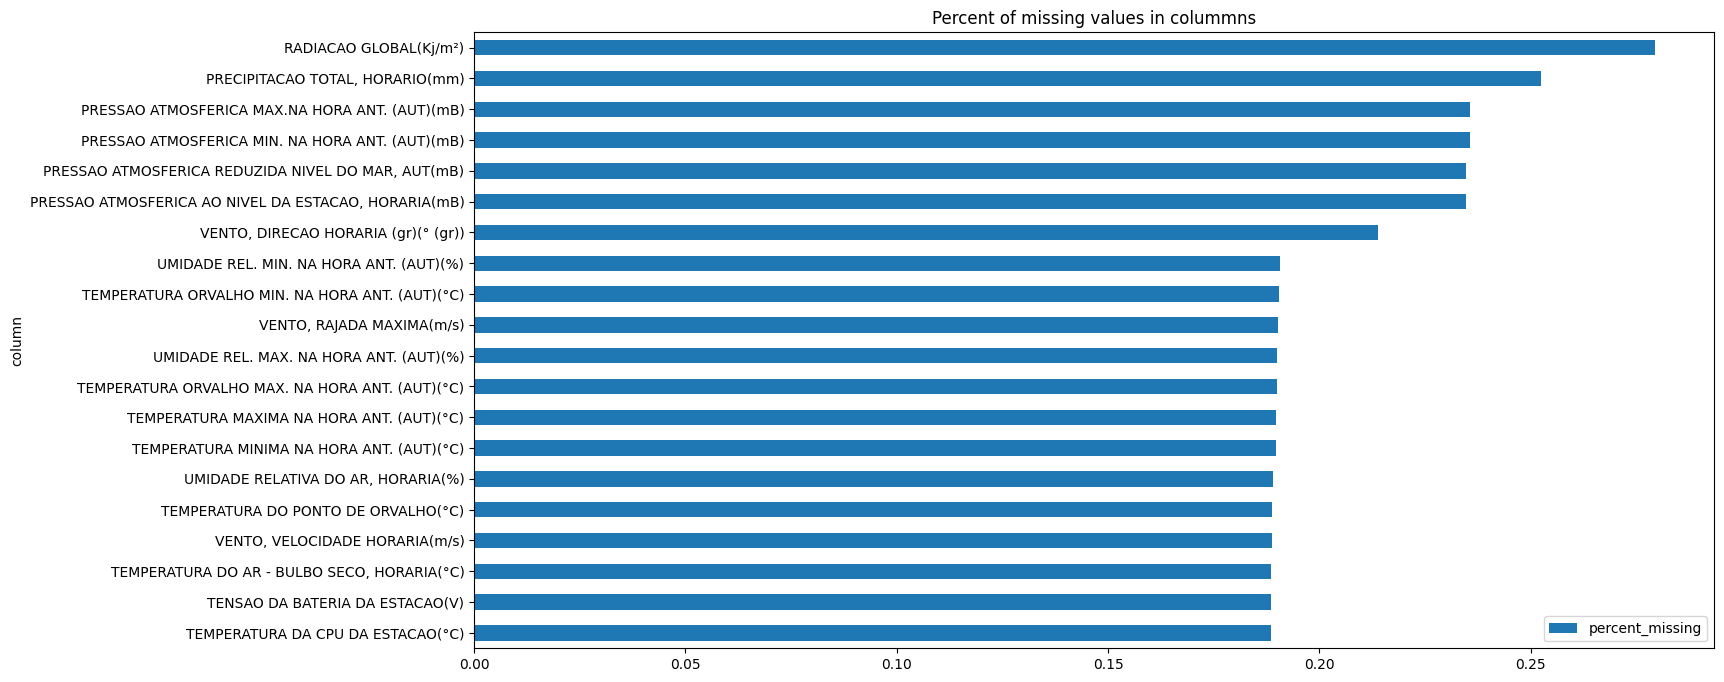

In [10]:
mytools.plot_missing_values(df)

In [11]:
df = ml_cropped.dropna()
ml_cropped.to_csv('processed_data/ml_cropped(2010-2020).csv')

In [12]:
col_numericas = [
    'PRECIPITACAO TOTAL, HORARIO(mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)',
    'PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)',
    'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)',
    'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)',
    'RADIACAO GLOBAL(Kj/m²)', 'TEMPERATURA DA CPU DA ESTACAO(°C)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)',
    'TEMPERATURA DO PONTO DE ORVALHO(°C)',
    'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)',
    'TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C)',
    'TENSAO DA BATERIA DA ESTACAO(V)',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)',
    'UMIDADE RELATIVA DO AR, HORARIA(%)', 'VENTO, RAJADA MAXIMA(m/s)',
    'VENTO, VELOCIDADE HORARIA(m/s)'
]

col_categoricas = ['estacao']

In [13]:
# features = ['TEMPERATURA DO PONTO DE ORVALHO(°C)','VENTO, VELOCIDADE HORARIA(m/s)', 'UMIDADE RELATIVA DO AR, HORARIA(%)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)']
parametros = (col_numericas + col_categoricas)
variavel = ['RADIACAO GLOBAL(Kj/m²)']
features = df[parametros]
target = df[variavel]
X = features.values
y = target.values

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)
from sklearn.model_selection import TimeSeriesSplit 
tss = TimeSeriesSplit(n_splits = 5,
                      gap = 2)

In [15]:
for train_index, test_index in tss.split(X):
    X_train, X_test = features.iloc[train_index, :], features.iloc[test_index,:]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

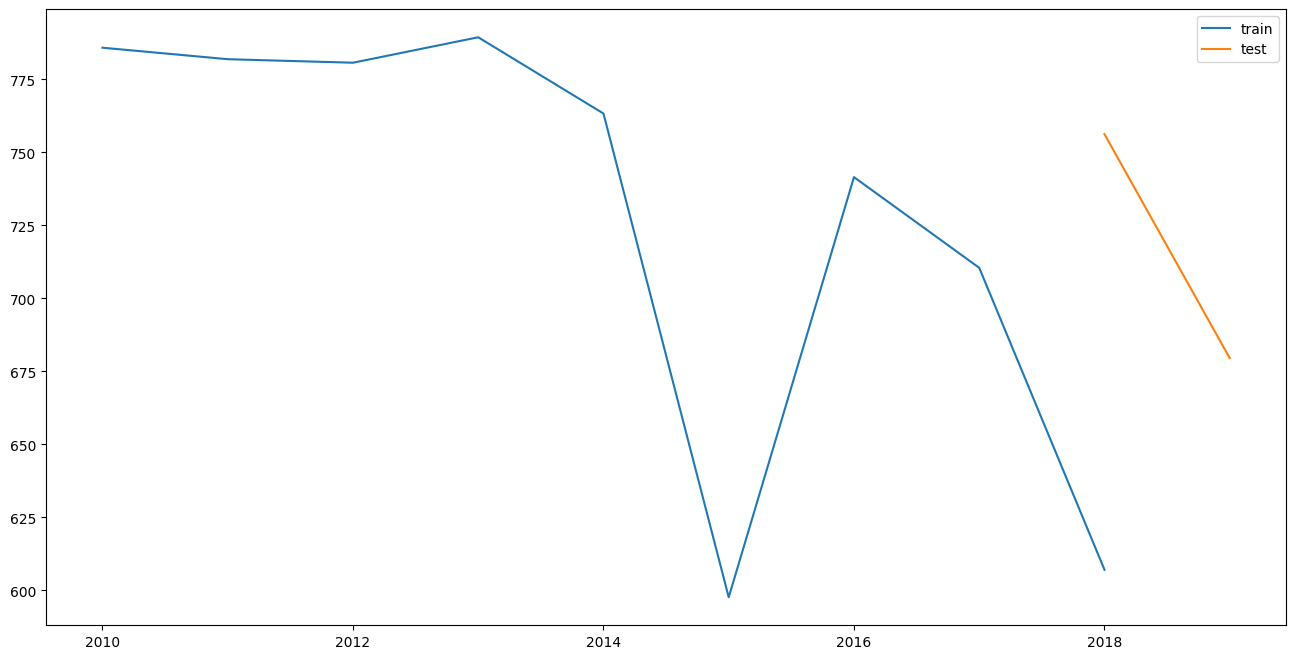

In [16]:
ax = plt.subplot()
ax.plot(y_train.groupby(df['Data_Hora'].dt.year).mean(), label = 'train')
ax.plot(y_test.groupby(df['Data_Hora'].dt.year).mean(), label = 'test')
ax.legend()
plt.show()

In [17]:
all_splits = list(tss.split(features, target))

In [18]:
train_idx, test_idx = all_splits[0]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

In [19]:
for fold, (train_index, test_index) in enumerate(tss.split(X,y)):
  X_train, X_test = features.iloc[train_index, :], features.iloc[test_index,:]
  y_train, y_test = target.iloc[train_index], target.iloc[test_index]
  print("Fold: {}".format(fold))
  print("\tTRAIN indices:", train_index)
  print("\tTEST indices:", test_index)
  # for fold,(train_index,test_index) in enumerate(tss.split(df)):
  
    

Fold: 0
	TRAIN indices: [    0     1     2 ... 12881 12882 12883]
	TEST indices: [12886 12887 12888 ... 25769 25770 25771]
Fold: 1
	TRAIN indices: [    0     1     2 ... 25767 25768 25769]
	TEST indices: [25772 25773 25774 ... 38655 38656 38657]
Fold: 2
	TRAIN indices: [    0     1     2 ... 38653 38654 38655]
	TEST indices: [38658 38659 38660 ... 51541 51542 51543]
Fold: 3
	TRAIN indices: [    0     1     2 ... 51539 51540 51541]
	TEST indices: [51544 51545 51546 ... 64427 64428 64429]
Fold: 4
	TRAIN indices: [    0     1     2 ... 64425 64426 64427]
	TEST indices: [64430 64431 64432 ... 77313 77314 77315]


In [20]:
#Criando Time-Lagging Features, can add freq = 1D, 1M, 1Y in shift function
#qual variavel devo adicionar o time lag?
'''
df.sort_values('date', inplace=True)
df['silver_lag_1'] = df['silver'].shift(1)
df['silver_lag_5'] = df['silver'].shift(5)
'''

"\ndf.sort_values('date', inplace=True)\ndf['silver_lag_1'] = df['silver'].shift(1)\ndf['silver_lag_5'] = df['silver'].shift(5)\n"

In [21]:
numeric_features = df[col_numericas]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values= np.nan ,strategy="median")),
        ("scaler", StandardScaler())]
)

categorical_features = df[col_categoricas]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, col_numericas),
        ("cat", categorical_transformer, col_categoricas),
    ]
)

# from imblearn.pipeline import Pipeline as kagglepipe
# from imblearn import FunctionSampler

# outlier_remover = kagglepipe(
#     steps = [
#         ('outlier_removal', FunctionSampler(func = mytools.CustomSampler_IQR(X_train,y_train),
#                                             validate =False))
    ]
)

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U6'), dtype('<U6')) -> None

In [ ]:
from sklearn.ensemble import RandomForestRegressor
Rf = RandomForestRegressor()
'''mypipe = mytools.Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", Rf)],
    verbose = True)
    '''

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", Rf)],
    verbose = True
)
from imblearn.pipeline import Pipeline as kagglepipe
from imblearn import FunctionSampler

# pipe = kagglepipe(
#     steps=[("outliers", 
#             "preprocessor", preprocessor), 
#            ("model", Rf)],
#     verbose = True


pipe.fit(X_train, y_train.values.ravel())
print("model score: %.3f" % pipe.score(X_test, y_test))


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.3min
model score: 1.000


In [ ]:
print("model score: %.3f" % pipe.score(X_test, y_test))

model score: 1.000


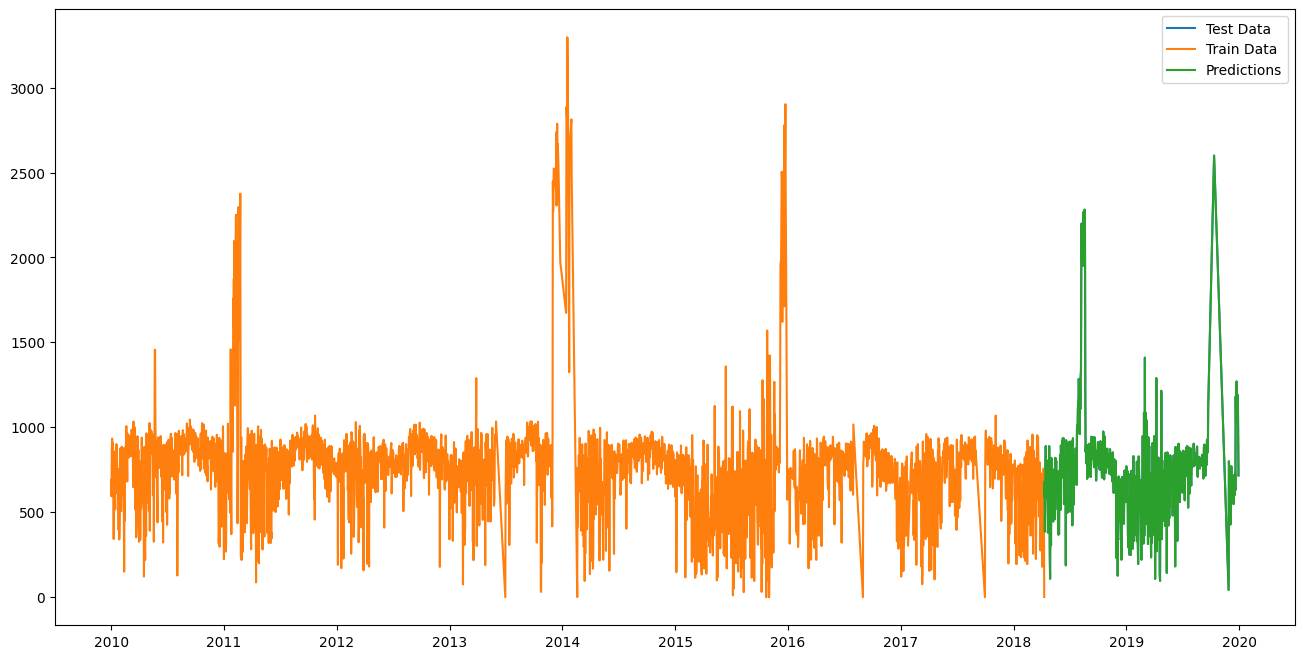

In [ ]:
y_pred = pipe.predict(X_test)
y_pred = pd.Series(y_pred, index = y_test.index)
fig, ax = plt.subplots()
ax.plot(y_test.groupby(df['Data_Hora'].dt.date).mean(), label='Test Data')
ax.plot(y_train.groupby(df['Data_Hora'].dt.date).mean(), label='Train Data')
ax.plot(y_pred.groupby(df['Data_Hora'].dt.date).mean(), label='Predictions')
ax.legend()
plt.show()

In [ ]:
import joblib
filename = "Models/Piperandomforestmodel.json"
joblib.dump(pipe,filename)

['Models/Piperandomforestmodel.json']

In [ ]:
loaded_model = joblib.load(filename)

In [ ]:
loaded_model.score(X_test, y_test)

0.9999999933209951